In [1]:
import numpy as np
import torch as tc

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from kinematics import pos_eq, limit_vals_to_ground
from stats import generate_rand_numbers, gaussian_norm, inverse_gaussian_norm
from model import BuildLinearLayer
from plots import plot_true_vs_pred, plot_projectile_motion

In [3]:
noise = True
dpi = 400
path = '../outputs/'

seed = 42 # Random number generator seed for producibility
tc.manual_seed(seed);

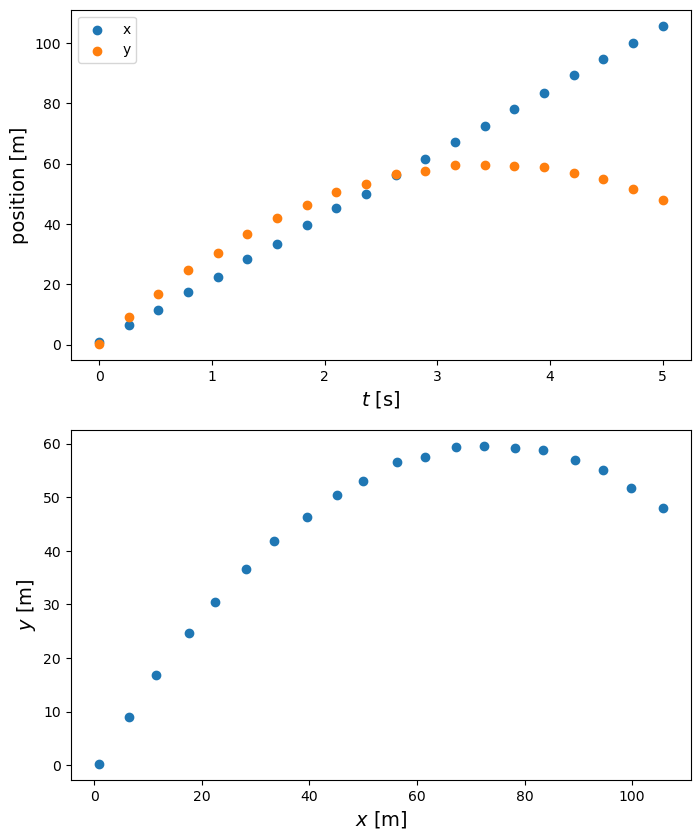

In [4]:
ax = tc.asarray([0])
g = tc.asarray([-9.81])

x0 = tc.asarray([0])
y0 = tc.asarray([0])
v0 = tc.asarray([40])
theta = tc.asarray([45])
v0x = v0*tc.cos(theta)
v0y = v0*tc.sin(theta)

t = tc.linspace(0, 5, 20)
x_t = pos_eq(x0, v0x, ax, t, noise)
y_t = pos_eq(y0, v0y, g, t, noise)

t, x_t, y_t = limit_vals_to_ground(t, x_t, y_t)

t_pred = tc.linspace(5.5, 8, 8).reshape(-1, 1)
x_t_pred = pos_eq(x0, v0x, ax, t_pred, noise)
y_t_pred = pos_eq(y0, v0y, g, t_pred, noise)

plot_projectile_motion(t, x_t, y_t, path, dpi)

In [5]:
a, b = t[0], t[-1]
t_rand = generate_rand_numbers(a, b, t.shape[0]).reshape(-1, 1)
x = pos_eq(x0, v0x, ax, t_rand, noise)

model = LinearRegression()
model.fit(t_rand, x)
x_skl = np.squeeze(model.predict(t_rand))
x_skl_pred = np.squeeze(model.predict(t_pred))

In [6]:
y = pos_eq(y0, v0y, g, t_rand, noise)

model = LinearRegression()
t_poly = tc.concat([t_rand, t_rand**2], dim=-1)
model.fit(t_poly, y)
y_skl = np.squeeze(model.predict(t_poly))

t_poly_pred = tc.cat([t_pred, t_pred**2], dim=1)
y_skl_pred = np.squeeze(model.predict(t_poly_pred))

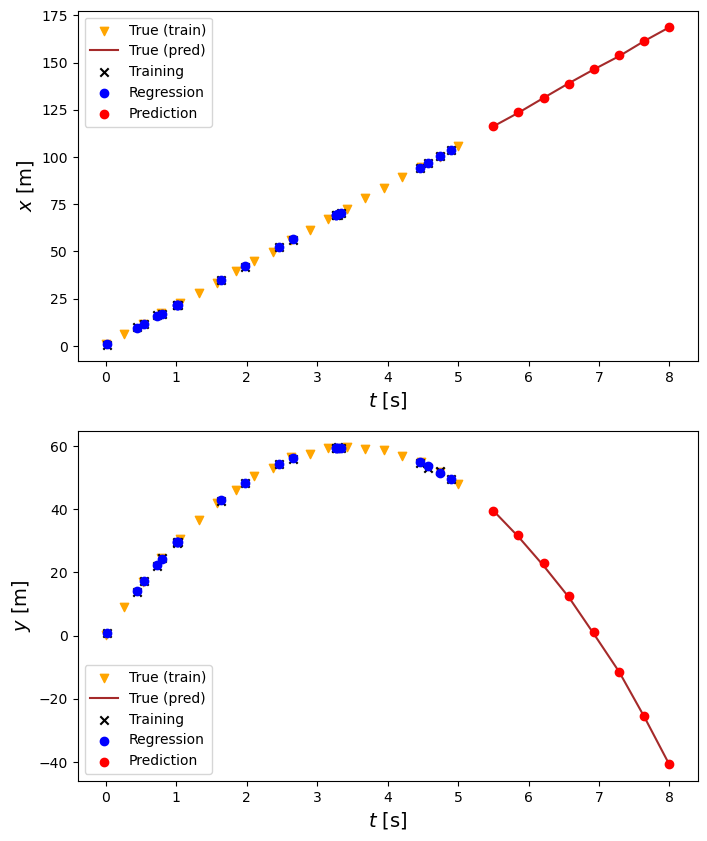

In [7]:
fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(8, 10))

ax1.scatter(t, x_t, label='True (train)', marker='v', color='orange')
ax1.plot(t_pred, x_t_pred, label='True (pred)', color='brown', zorder=-1)
ax1.scatter(t_rand, x, color='k', marker='x', label='Training')
ax1.scatter(t_rand, x_skl, marker='o', color='b', label='Regression')
ax1.scatter(t_pred, x_skl_pred, color='r', label='Prediction')
ax1.set_xlabel('$t$ [s]', fontsize=14)
ax1.set_ylabel('$x$ [m]', fontsize=14)
ax1.legend(loc='upper left')

ax2.scatter(t, y_t, label='True (train)', marker='v', color='orange')
ax2.plot(t_pred, y_t_pred, label='True (pred)', color='brown', zorder=-1)
ax2.scatter(t_rand, y, color='k', marker='x', label='Training')
ax2.scatter(t_rand, y_skl, marker='o', color='b', label='Regression')
ax2.scatter(t_pred, y_skl_pred, color='r', label='Prediction')
ax2.set_xlabel('$t$ [s]', fontsize=14)
ax2.set_ylabel('$y$ [m]', fontsize=14)
ax2.legend(loc='lower left')

# plt.suptitle("Using Scikit-learn's linear regression")
plt.show();

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01)
fig.savefig(path + 'linear_reg_sklearn.png', bbox_inches='tight', dpi=dpi)

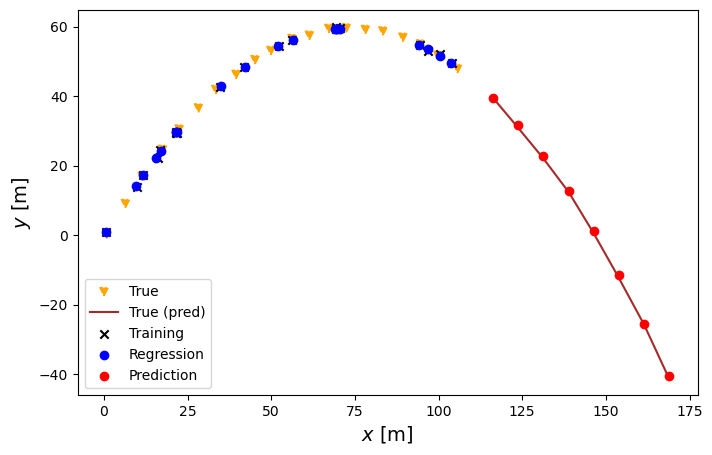

In [8]:
fig = plt.figure(figsize=(8, 5))

plt.scatter(x_t, y_t, label='True', marker='v', color='orange', ls='-.')
plt.plot(x_t_pred, y_t_pred, label='True (pred)', color='brown', zorder=-1)
plt.scatter(x, y, color='k', marker='x', label='Training')
plt.scatter(x_skl, y_skl, marker='o', color='b', label='Regression')
plt.scatter(x_skl_pred, y_skl_pred, color='r', label='Prediction')
plt.xlabel('$x$ [m]', fontsize=14)
plt.ylabel('$y$ [m]', fontsize=14)

# plt.title("Using Scikit-learn's linear regression")
plt.legend(loc='lower left')
plt.show();

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01)
fig.savefig(path + 'linear_reg_skl_y_vs_x.png', bbox_inches='tight', dpi=dpi)

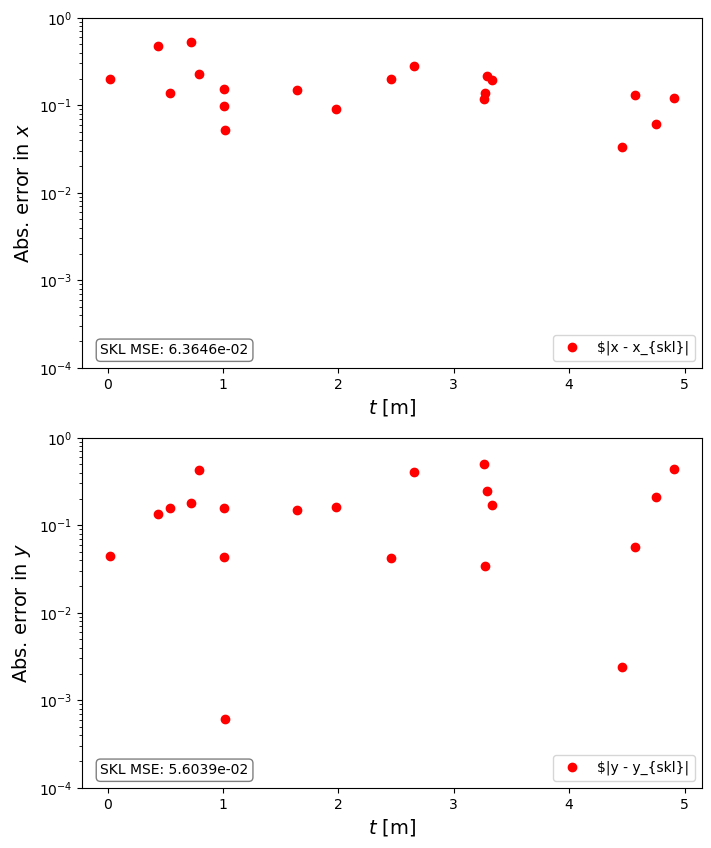

In [9]:
fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(8, 10))

ax1.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(x)) - np.sort(x_skl)), 
             'o', color='r', label='$|x - x_{skl}|')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.03, 0.03, f'SKL MSE: {mean_squared_error(x, x_skl):.4e}', 
        transform=ax1.transAxes, verticalalignment='bottom', bbox=props)

ax1.set_xlabel('$t$ [m]', fontsize=14)
ax1.set_ylabel('Abs. error in $x$', fontsize=14)
ax1.set_ylim(1e-4, 1)
ax1.legend(loc='lower right')

ax2.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(y)) - np.sort(y_skl)), 
             'o', color='r', label='$|y - y_{skl}|')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax2.text(0.03, 0.03, f'SKL MSE: {mean_squared_error(y, y_skl):.4e}', 
        transform=ax2.transAxes, verticalalignment='bottom', bbox=props)

ax2.set_xlabel('$t$ [m]', fontsize=14)
ax2.set_ylabel('Abs. error in $y$', fontsize=14)
ax2.set_ylim(1e-4, 1)
ax2.legend(loc='lower right')

plt.show();

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01)
fig.savefig(path + 'linear_reg_abs_err_skl.png', bbox_inches='tight', dpi=dpi)

In [10]:
t_std, t_mean = tc.std(t_rand), tc.mean(t_rand)
x_std, x_mean = tc.std(x), tc.mean(x)
y_std, y_mean = tc.std(y), tc.mean(y)

t_norm = gaussian_norm(t_rand, t_std, t_mean)
x_norm = gaussian_norm(x, x_std, x_mean)
y_norm = gaussian_norm(y, y_std, y_mean)

epoch = 100, loss = 0.013615655712783337


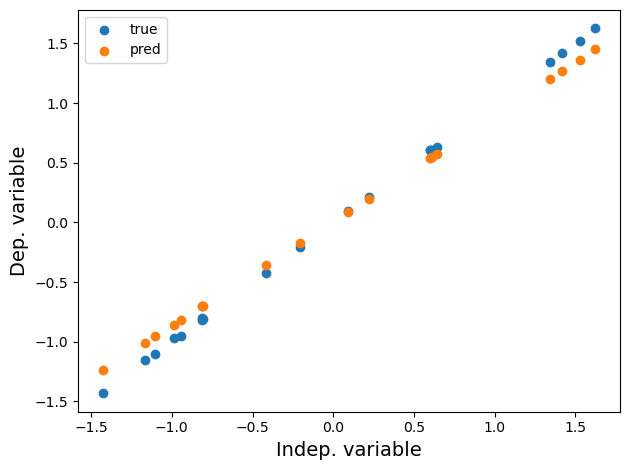

epoch = 200, loss = 0.0003835084498859942


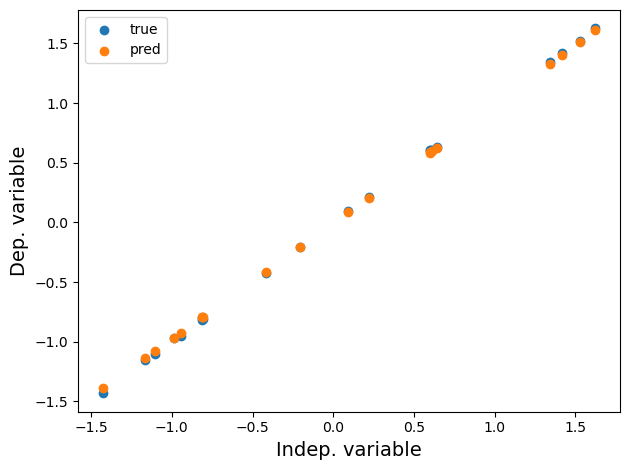

epoch = 300, loss = 7.699328125454485e-05


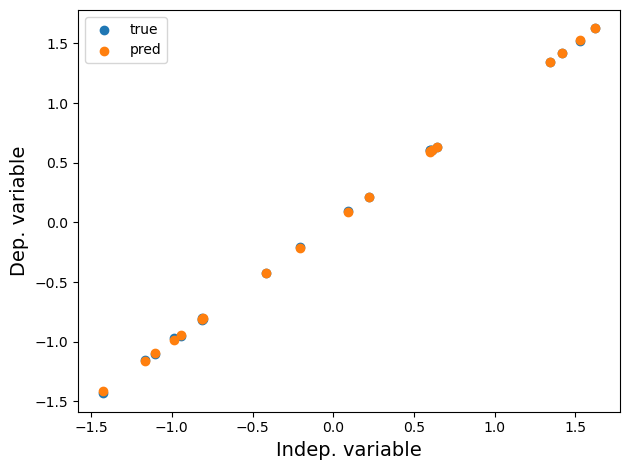

epoch = 400, loss = 6.0432892496464774e-05


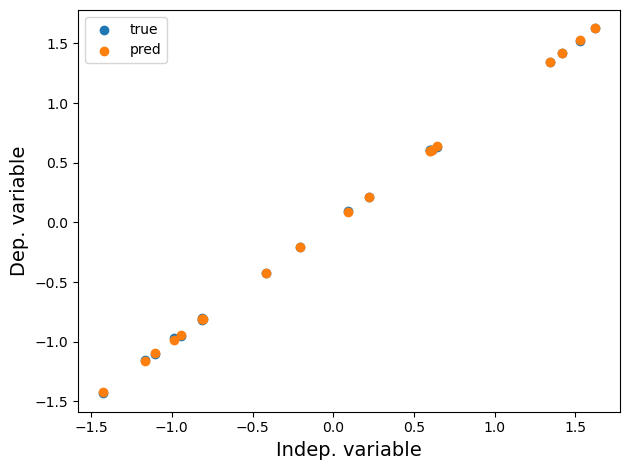

epoch = 500, loss = 5.642818723572418e-05


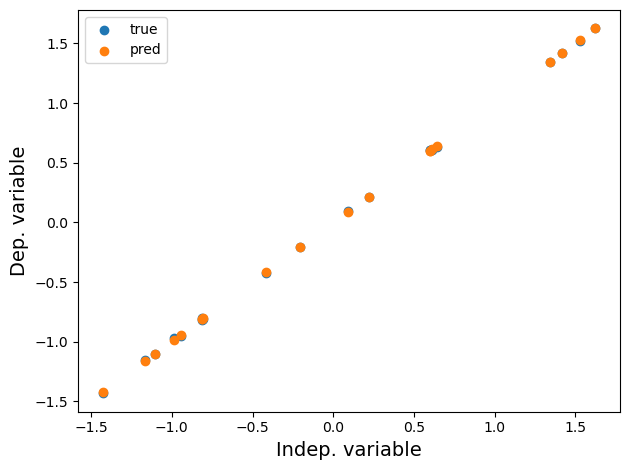

Training done
Epoch = 581, loss = 5.518407124327496e-05
Residual: 9.840732673183084e-09 < 1e-08


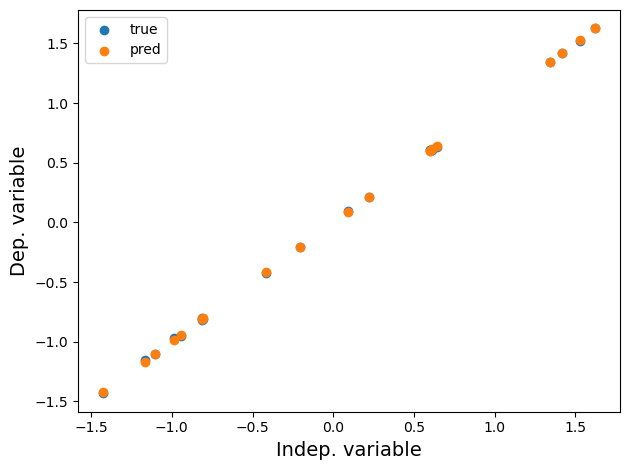

In [11]:
epochs = 2000
lr = 0.01

my_ll = BuildLinearLayer([2, 1], lr)
my_ll.train(t_norm, x_norm, epochs)
x_ll_norm = my_ll.predict(t_norm)
x_ll = inverse_gaussian_norm(x_ll_norm, x_std, x_mean)

t_pred_norm = gaussian_norm(t_pred, t_std, t_mean)
x_ll_pred_norm = my_ll.predict(t_pred_norm)
x_ll_pred = inverse_gaussian_norm(x_ll_pred_norm, x_std, x_mean)

epoch = 100, loss = 0.21558931469917297


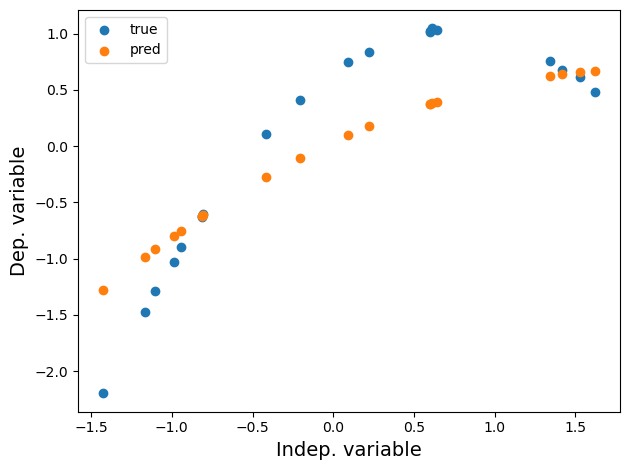

epoch = 200, loss = 0.0689425840973854


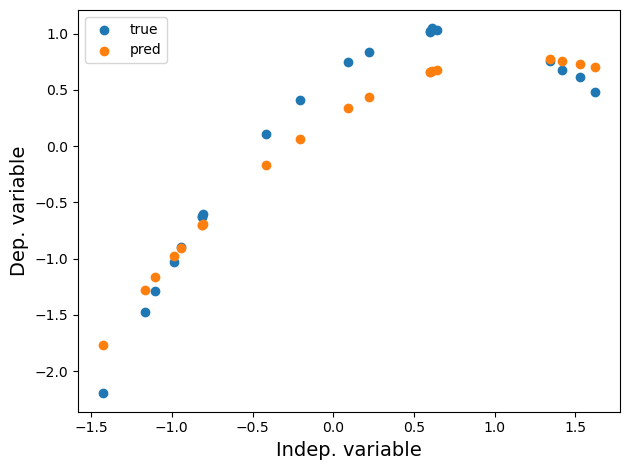

epoch = 300, loss = 0.025004511699080467


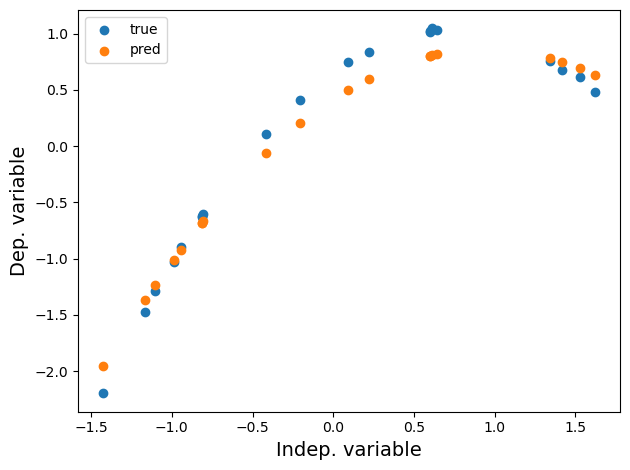

epoch = 400, loss = 0.00920779537409544


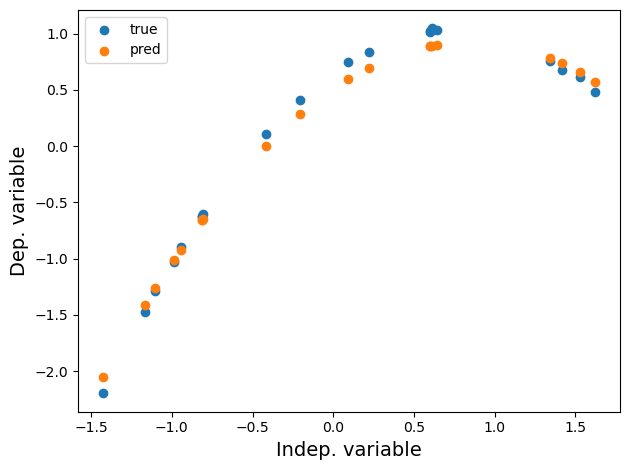

epoch = 500, loss = 0.003460413310676813


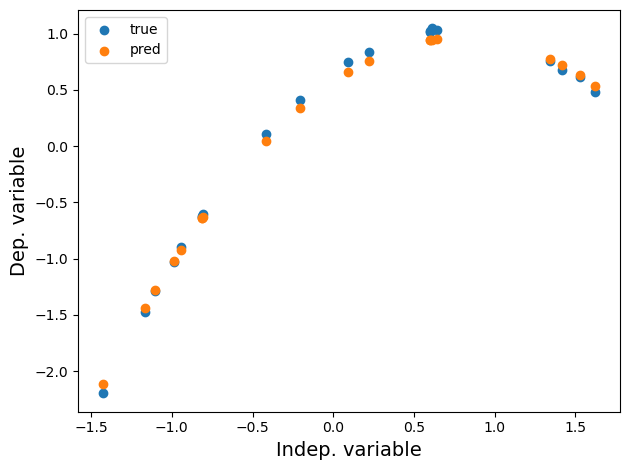

epoch = 600, loss = 0.001367840450257063


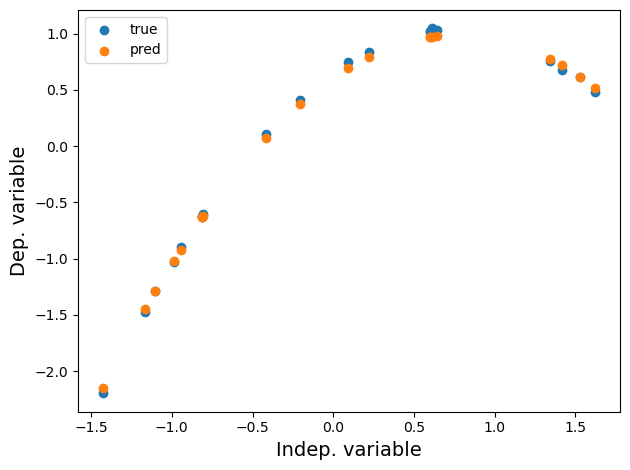

epoch = 700, loss = 0.0006059143925085664


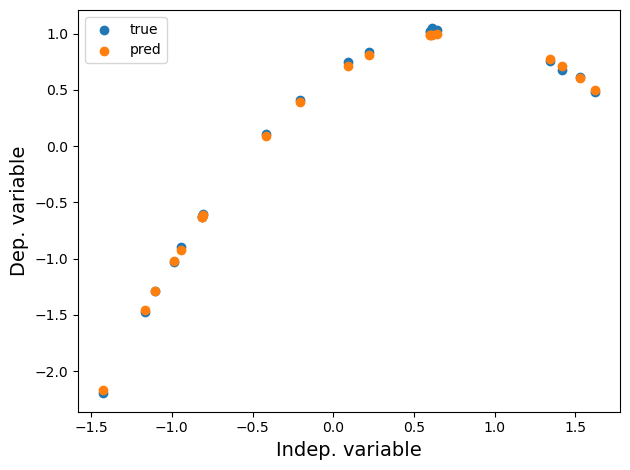

epoch = 800, loss = 0.00032849787385202944


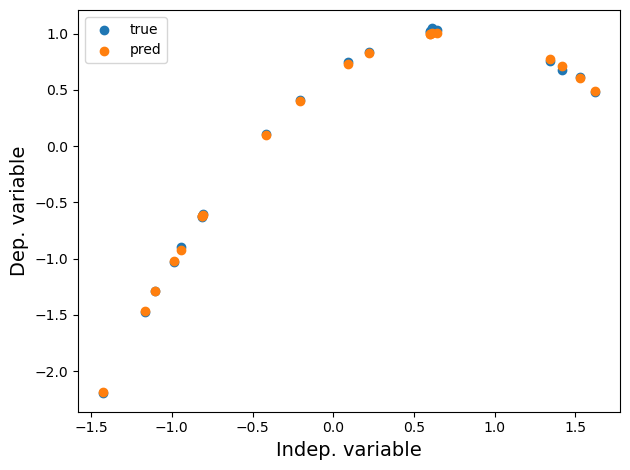

epoch = 900, loss = 0.00022748392075300217


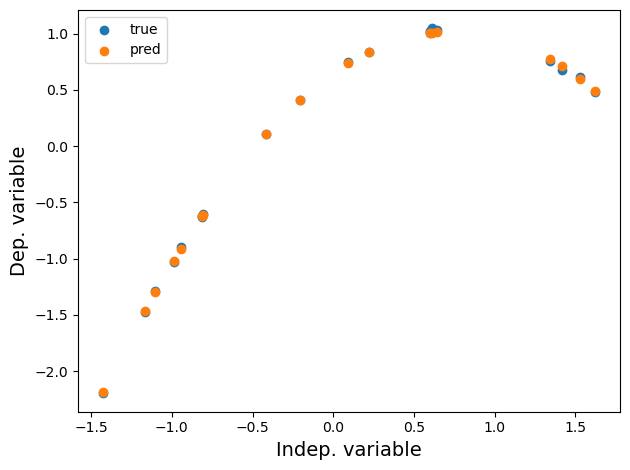

epoch = 1000, loss = 0.00019070641428697854


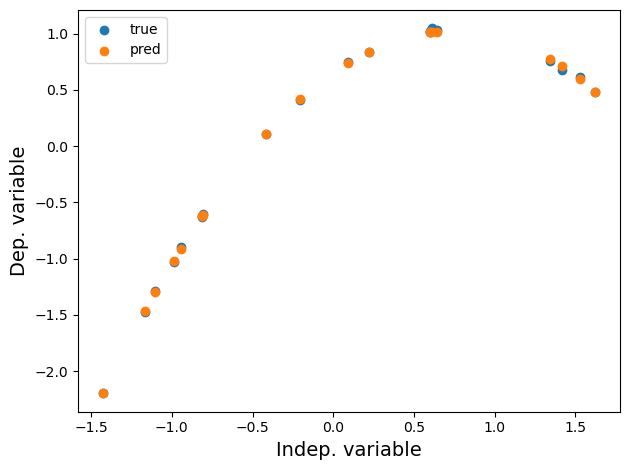

epoch = 1100, loss = 0.00017731543630361557


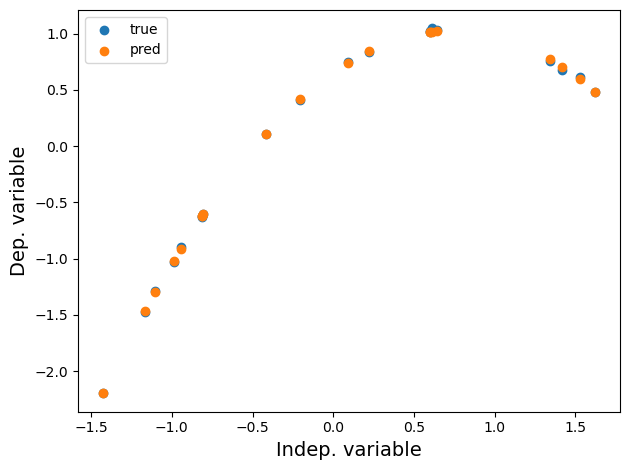

epoch = 1200, loss = 0.0001724391768220812


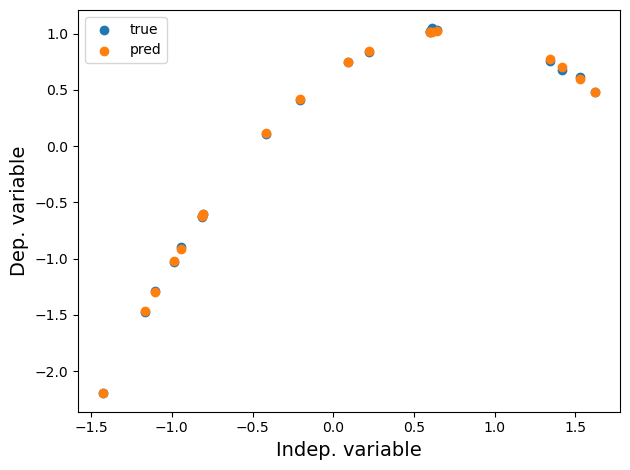

epoch = 1300, loss = 0.00017066416330635548


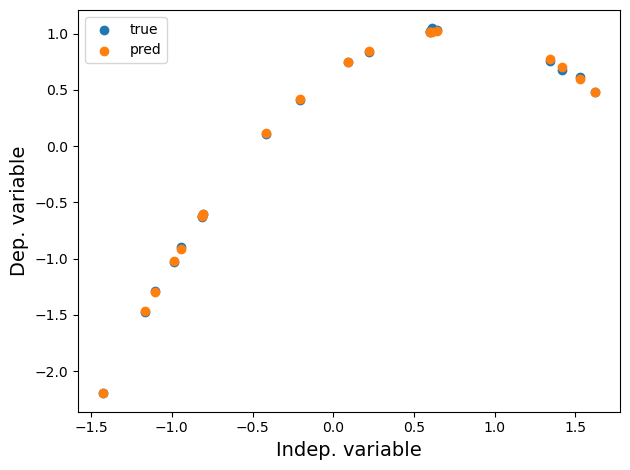

Training done
Epoch = 1302, loss = 0.00017064374696929008
Residual: 9.851646609604359e-09 < 1e-08


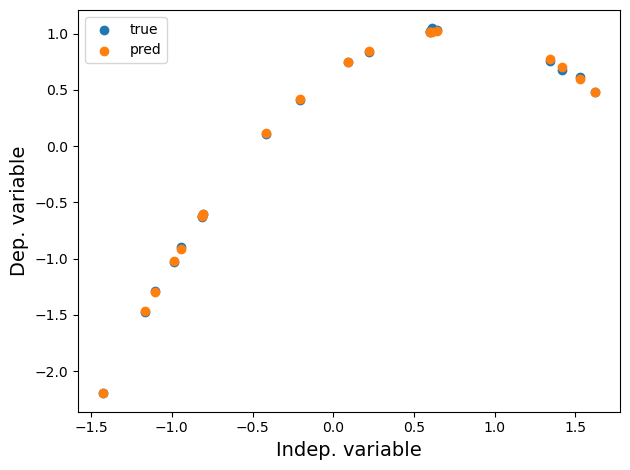

In [12]:
my_ll = BuildLinearLayer([2, 1], lr)
my_ll.train(t_norm, y_norm, epochs)
y_ll_norm = my_ll.predict(t_norm)
y_ll = inverse_gaussian_norm(y_ll_norm, y_std, y_mean)

t_pred_norm = gaussian_norm(t_pred, t_std, t_mean)
y_ll_pred_norm = my_ll.predict(t_pred_norm)
y_ll_pred = inverse_gaussian_norm(y_ll_pred_norm, y_std, y_mean)

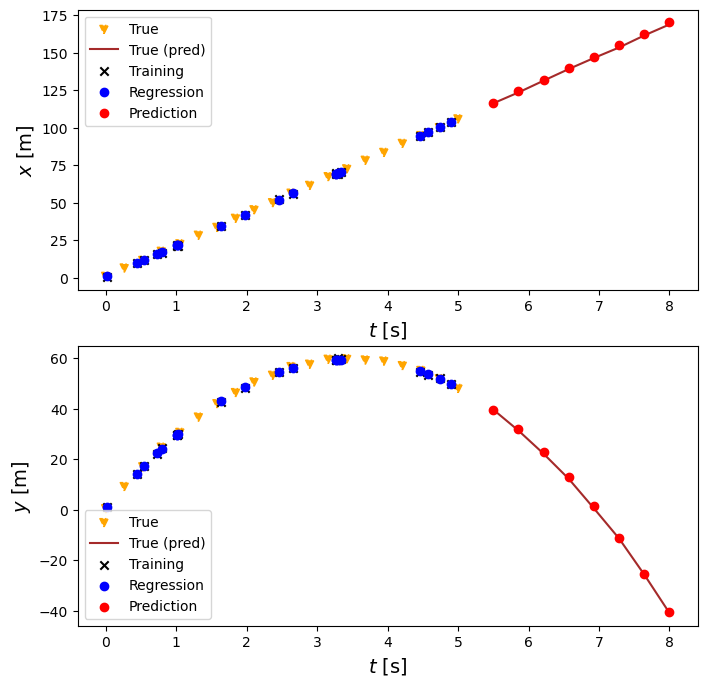

In [13]:
fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(8, 8))

ax1.scatter(t, x_t, label='True', marker='v', color='orange', ls='-.')
ax1.plot(t_pred, x_t_pred, label='True (pred)', color='brown', zorder=-1)
ax1.scatter(t_rand, x, color='k', marker='x', label='Training')
ax1.scatter(t_rand, x_ll, marker='o', color='b', label='Regression')
ax1.scatter(t_pred, x_ll_pred, color='r', label='Prediction')
ax1.set_xlabel('$t$ [s]', fontsize=14)
ax1.set_ylabel('$x$ [m]', fontsize=14)
ax1.legend(loc='upper left')

ax2.scatter(t, y_t, label='True', marker='v', color='orange', ls='-.')
ax2.plot(t_pred, y_t_pred, label='True (pred)', color='brown', zorder=-1)
ax2.scatter(t_rand, y, color='k', marker='x', label='Training')
ax2.scatter(t_rand, y_ll, marker='o', color='b', label='Regression')
ax2.scatter(t_pred, y_ll_pred, color='r', label='Prediction')
ax2.set_xlabel('$t$ [s]', fontsize=14)
ax2.set_ylabel('$y$ [m]', fontsize=14)
ax2.legend(loc='lower left')

# plt.suptitle("Using PyTorch's linear layer")
plt.show();

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01)
fig.savefig(path + 'linear_reg_ll.png', bbox_inches='tight', dpi=dpi)

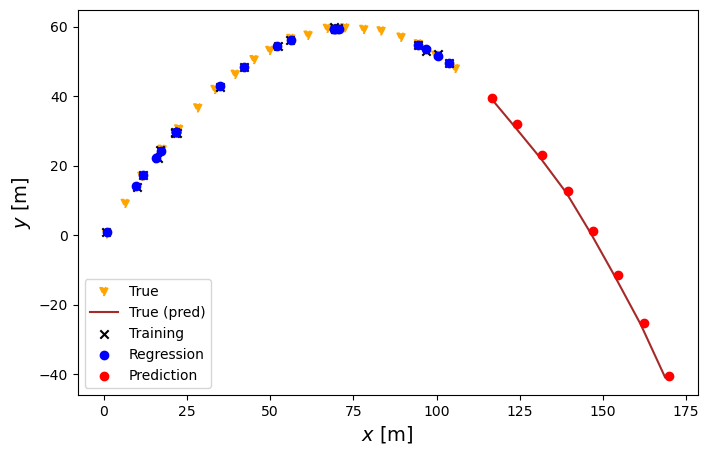

In [14]:
fig = plt.figure(figsize=(8, 5))

plt.scatter(x_t, y_t, label='True', marker='v', color='orange', ls='-.')
plt.plot(x_t_pred, y_t_pred, label='True (pred)', color='brown', zorder=-1)
plt.scatter(x, y, color='k', marker='x', label='Training')
plt.scatter(x_ll, y_ll, marker='o', color='b', label='Regression')
plt.scatter(x_ll_pred, y_ll_pred, color='r', label='Prediction')
plt.xlabel('$x$ [m]', fontsize=14)
plt.ylabel('$y$ [m]', fontsize=14)

# plt.title("Using PyTorch's linear layer")
plt.legend(loc='lower left')
plt.show();

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01)
fig.savefig(path + 'linear_reg_ll_y_vs_x.png', bbox_inches='tight', dpi=dpi)

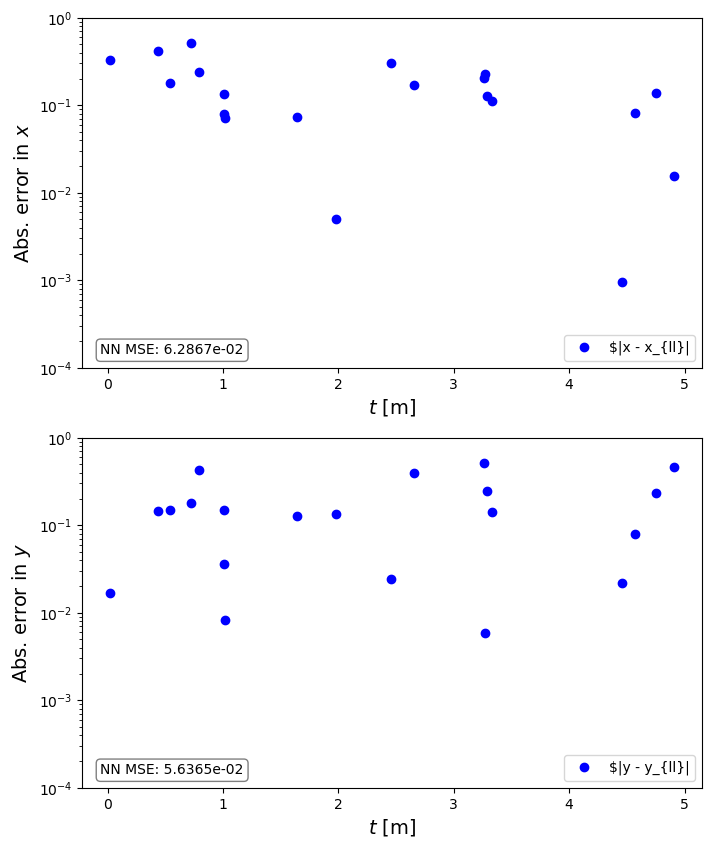

In [15]:
fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(8, 10))

ax1.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(x)) - np.sort(x_ll)), 
             'o',  color='b', label='$|x - x_{ll}|')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.03, 0.03, f'NN MSE: {mean_squared_error(x, x_ll):.4e}', 
        transform=ax1.transAxes, verticalalignment='bottom', bbox=props)

ax1.set_xlabel('$t$ [m]', fontsize=14)
ax1.set_ylabel('Abs. error in $x$', fontsize=14)
ax1.set_ylim(1e-4, 1)
ax1.legend(loc='lower right')

ax2.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(y)) - np.sort(y_ll)), 
             'o', color='b', label='$|y - y_{ll}|')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax2.text(0.03, 0.03, f'NN MSE: {mean_squared_error(y, y_ll):.4e}', 
        transform=ax2.transAxes, verticalalignment='bottom', bbox=props)

ax2.set_xlabel('$t$ [m]', fontsize=14)
ax2.set_ylabel('Abs. error in $y$', fontsize=14)
ax2.set_ylim(1e-4, 1)
ax2.legend(loc='lower right')

plt.show();

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01)
fig.savefig(path + 'linear_reg_abs_err_ll.png', bbox_inches='tight', dpi=dpi)

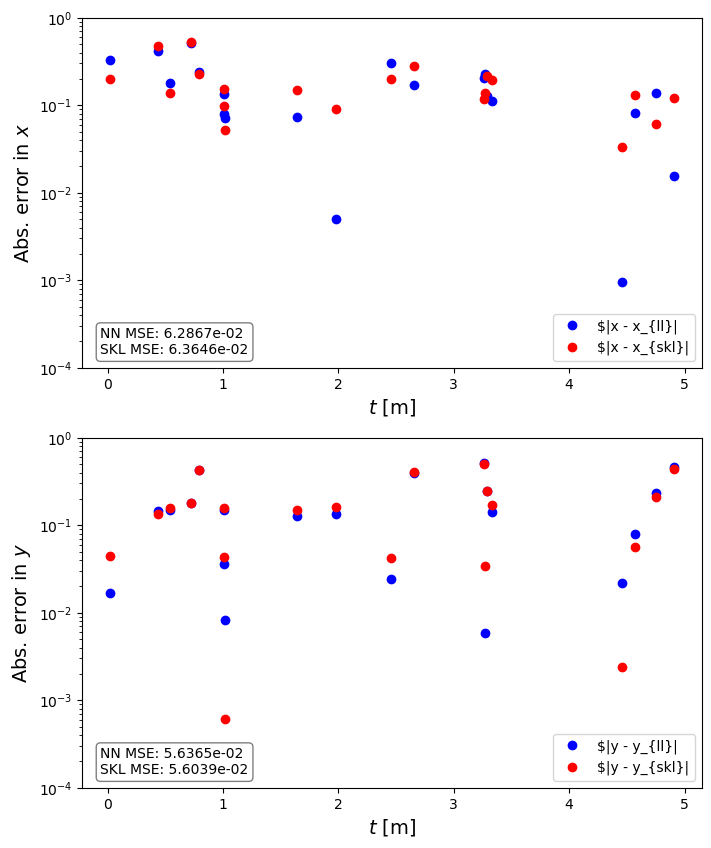

In [16]:
fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(8, 10))

ax1.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(x)) - np.sort(x_ll)), 
             'o',  color='b', label='$|x - x_{ll}|')
ax1.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(x)) - np.sort(x_skl)), 
             'o', color='r', label='$|x - x_{skl}|')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.03, 0.03, f'NN MSE: {mean_squared_error(x, x_ll):.4e}' + '\n' +
                   f'SKL MSE: {mean_squared_error(x, x_skl):.4e}', 
        transform=ax1.transAxes, verticalalignment='bottom', bbox=props)

ax1.set_xlabel('$t$ [m]', fontsize=14)
ax1.set_ylabel('Abs. error in $x$', fontsize=14)
ax1.set_ylim(1e-4, 1)
ax1.legend(loc='lower right')

ax2.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(y)) - np.sort(y_ll)), 
             'o', color='b', label='$|y - y_{ll}|')
ax2.semilogy(np.sort(tc.squeeze(t_rand)), abs(np.sort(tc.squeeze(y)) - np.sort(y_skl)), 
             'o', color='r', label='$|y - y_{skl}|')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax2.text(0.03, 0.03, f'NN MSE: {mean_squared_error(y, y_ll):.4e}' + '\n' +
                   f'SKL MSE: {mean_squared_error(y, y_skl):.4e}', 
        transform=ax2.transAxes, verticalalignment='bottom', bbox=props)

ax2.set_xlabel('$t$ [m]', fontsize=14)
ax2.set_ylabel('Abs. error in $y$', fontsize=14)
ax2.set_ylim(1e-4, 1)
ax2.legend(loc='lower right')

plt.show();

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01)
fig.savefig(path + 'linear_reg_abs_err_both.png', bbox_inches='tight', dpi=dpi)